In [1]:
# Will
# 4.30
# GPUCB with beerslaw

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

from scipy.stats import pearsonr
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity

from importlib import reload
import itertools

from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.metrics

import beers_law.physics_models
import UCB.ucb

In [3]:
def noise(size):
    return np.random.normal(loc=0, scale=1.5, size=size)

def make_solution(amts, dye):
    """
    Calculates concentration from volumes and dye concentrations
    """
    n = noise(4)
    
    red_ul = amts[0] + n[0]
    green_ul = amts[1] + n[1]
    blue_ul = amts[2] + n[2]
    water_ul = amts[3] + n[3]
    
    #makign sure we aren't adding negative volumes
    if red_ul < 0:
        red_ul = 0
    if green_ul < 0:
        green_ul = 0
    if blue_ul < 0:
        blue_ul = 0
    if water_ul < 0:
        water_ul = 0
    
    
    total = red_ul + green_ul + blue_ul + water_ul
    red = red_ul * dye['red'] / total
    green = green_ul * dye['green'] / total
    blue = blue_ul * dye['blue'] / total
    return {'red': red, 'green': green, 'blue': blue}

In [4]:
class BeersEnvironment(object):
    def __init__(self, target, coeffs, dye):
        # in future this will be basis spectra
        self.target = target
        self.coeffs = coeffs
        self.dye = dye
    
    def sample(self, action):
        sol = make_solution(action, self.dye)
        result = beers_law.physics_models.beers_law(sol, 1, coeff, 300, 700)[1]
        mse = sklearn.metrics.mean_squared_error(result, self.target)
        cos = sklearn.metrics.pairwise.cosine_similarity([result], [self.target])
        #print(cos)
        #print(mse)
        return cos
        return -mse
        return pearsonr(result, self.target)[0]

In [5]:
red = np.arange(0, 301, 10)
green = np.arange(0, 301, 10)
blue = np.arange(0, 301, 10)
water = np.arange(0, 301, 10)
grid = np.meshgrid(red, green, blue, water)

coeff = pd.read_csv('beers_law/rgb_coeff')
coeff.drop(labels='Unnamed: 0', axis=1, inplace=True)
spectra = beers_law.physics_models.random_spectra(1, coeff, 300, 700, .3)

dye = {'red': 5, 'blue': 5, 'green': 5}

env = BeersEnvironment(spectra[1], coeff, dye)
batch_size = 8

agent = UCB.ucb.BatchGPUCB(batch_size, grid, env, 200)

In [6]:
for i in range(8):
    agent.learn()

In [7]:
def plot_beers_batches(data, target):
    """
    Plots each batch and target from agent
    """
    fig, axs = plt.subplots(nrows=len(data), ncols=1, figsize=(8, 30))
    axs = axs.flatten()
    count = 0
    for batch in data:
        axs[count].plot(target[0], target[1], color = 'black')
        for amts in batch:
            sol = make_solution(amts, dye)
            guess = beers_law.physics_models.beers_law(sol, 1, coeff, 300, 700)[1]
            axs[count].plot(spectra[0], guess, alpha = .5)

        count += 1

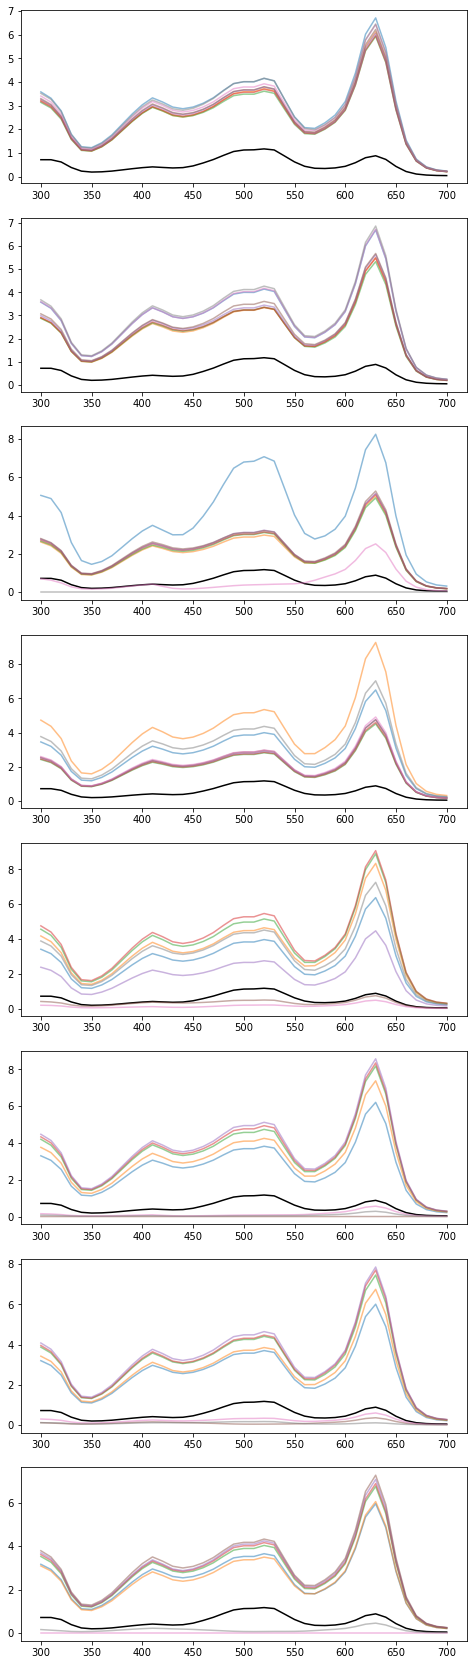

In [8]:
plot_beers_batches(agent.X, spectra)